<a href="https://colab.research.google.com/github/aburak256/Currency-with-Twitter/blob/main/predictions_difference_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
import gluonts
from math import sqrt

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones


from pandas.plotting import autocorrelation_plot
from metrics import evaluate
from plots import bar_metrics
from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization
import csv
seed = 42
tf.random.set_seed(seed)

np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.4.0


In [ ]:
exchange_rate = pd.read_csv('difference.csv',parse_dates=['Date'])
exchange_rate.set_index('Date',inplace=True)
exchange_rate.head()

,Rate,Previous,Lag1Order2,Direction
Date,,,,
2014-01-01 18:00:00,-0.00107,2.14793,0.00054,0
2014-01-01 19:01:00,-0.00006,2.14686,-0.00045,0
2014-01-01 20:00:00,0.00048,2.14680,-0.00037,1
2014-01-01 21:00:00,0.00003,2.14728,0.00034,1
2014-01-01 22:01:00,-0.00034,2.14731,-0.00041,0


In [ ]:
exchange_rate.describe()

,Rate,Previous,Lag1Order2,USD_TRYCount,USD_TRYLike,USD_TRYRt,DolarCount,DolarLike,DolarRt,merkezBankasiCount,merkezBankasiLike,merkezBankasiRt,TurkLirasiCount,TurkLirasiLike,TurkLirasiRt,Direction
count,37196.000000,37196.000000,3.719600e+04,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000
mean,0.000102,3.687574,-3.629423e-08,10.096247,39.506963,6.640391,92.162410,704.844284,704.844284,9.647193,72.799199,24.477309,2.094688,24.734918,7.205237,0.503818
std,0.010408,1.283822,1.526339e-02,11.755379,122.692579,20.875975,225.979866,3693.251096,3693.251096,32.840221,726.427216,177.578843,6.938054,301.574472,83.768961,0.499992
min,-0.343970,2.063250,-1.054890e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.002190,2.707673,-3.350000e-03,2.000000,0.000000,0.000000,29.000000,22.000000,22.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000020,3.468835,4.000000e-05,7.000000,2.000000,1.000000,59.000000,87.000000,87.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,0.002233,4.734565,3.440000e-03,14.000000,21.000000,5.000000,101.000000,379.000000,379.000000,8.000000,12.000000,7.000000,2.000000,2.000000,0.000000,1.000000
max,0.710920,7.096780,7.686800e-01,311.000000,5147.000000,1570.000000,10368.000000,229976.000000,229976.000000,2218.000000,70139.000000,11982.000000,392.000000,21082.000000,8202.000000,1.000000


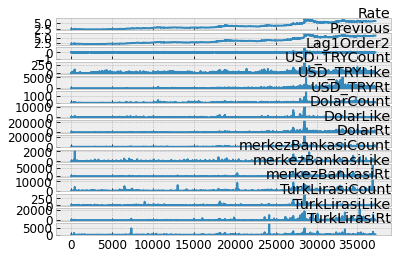

In [ ]:
values = exchange_rate.values
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)

    plt.plot(values[:, group])
    plt.title(exchange_rate.columns[group], y=0.5, loc='right')
    i += 1
    

plt.show()

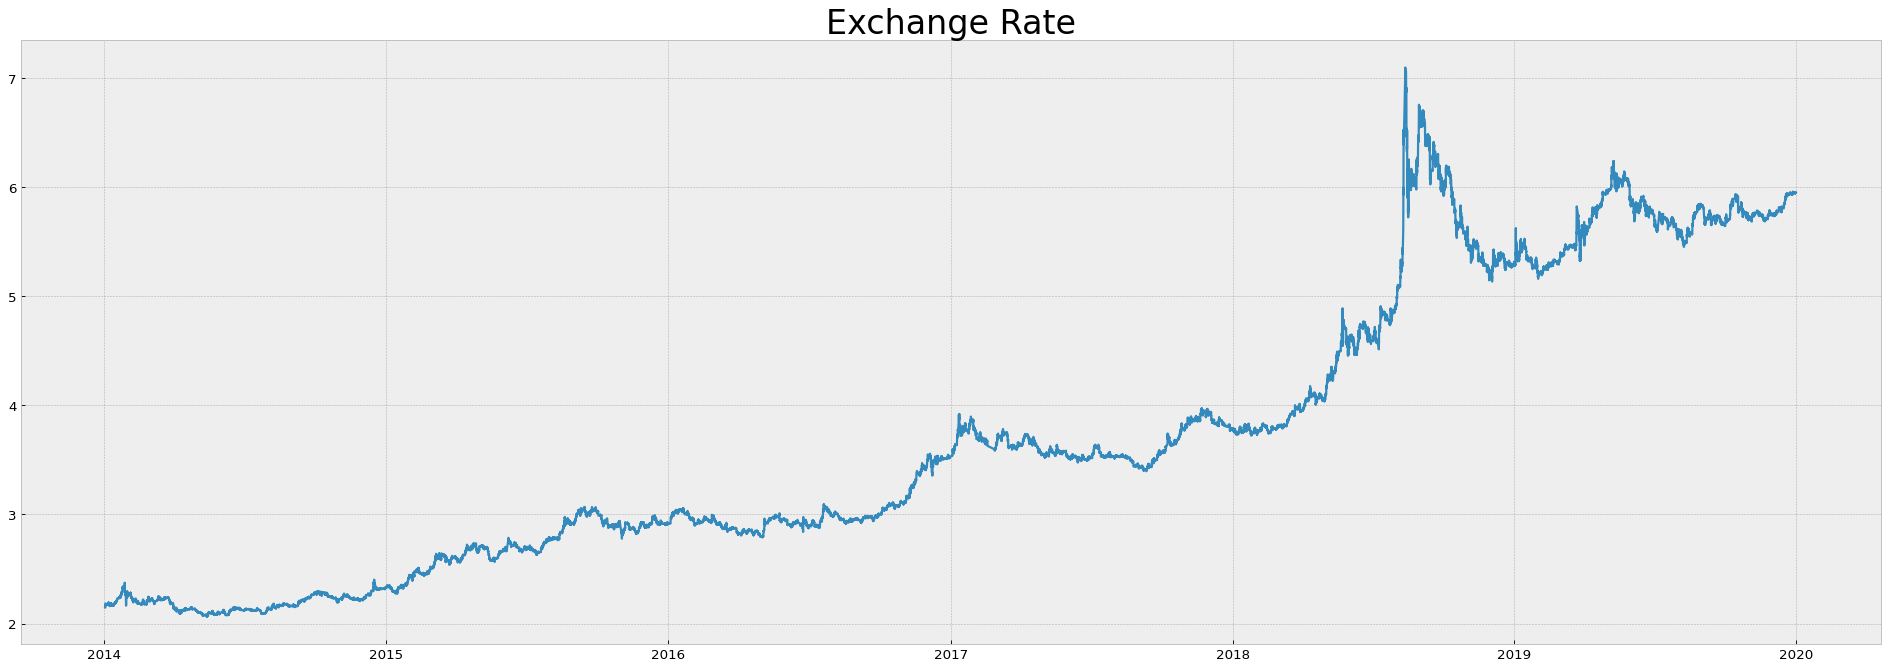

In [ ]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Exchange Rate',fontsize=30)

plt.plot(exchange_rate.Rate)
plt.savefig("rate.png")

## Making time series stationary

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

difference(t) = observation(t) - observation(t-1)

In [ ]:
resultsDict={}
predictionsDict={}

split_date ='2019-01-01 00:00'
df_training = exchange_rate.loc[exchange_rate.index <= split_date]
df_test = exchange_rate.loc[exchange_rate.index > split_date]
print(f"{len(df_training)} hours of training data \n {len(df_test)} hours of testing data ")


df_training.to_csv('training.csv')
df_test.to_csv('test.csv')


30958 hours of training data 
 6238 hours of testing data 


In [ ]:
mean = df_test.Rate.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.Rate, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(df_test.Rate, df_test.Previous)
predictionsDict['Yesterdays value'] = df_test.Previous.values
predictionsDict['ORIGINAL'] = df_test.Rate.values

In [ ]:
def create_time_features(df,target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'],axis=1)
    if target:
        y = df[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [ ]:
X_train_df, y_train = create_time_features(df_training, target='Rate')
X_test_df, y_test = create_time_features(df_test, target='Rate')
scaler = StandardScaler() 
scaler.fit(X_train_df) 
X_train = scaler.transform(X_train_df)  
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train,columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test,columns=X_test_df.columns)

In [ ]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.Rate, yhat)
predictionsDict['BayesianRidge'] = yhat

Test MSE: 0.00009224


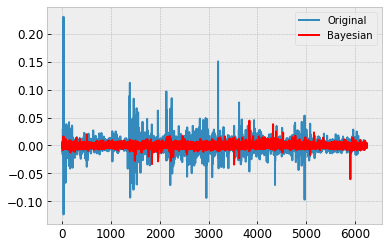

In [ ]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='Bayesian')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

In [ ]:
reg = linear_model.Lasso(alpha=0.0001) #If alpha value increase, models complexity reduces. So set the alpha value smaller
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.Rate, yhat)
predictionsDict['Lasso'] = yhat

Test MSE: 0.00009076


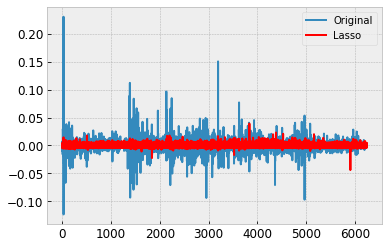

In [ ]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='Lasso')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)              

Tested alpha values to get a better result.

Minimum alpha value for result is 0.0001. If we choose smaller alpha it didn't changes the MSE.

alpha = 0.01 MSE = 0.0003


In [ ]:
reg = RandomForestRegressor(max_depth=16, random_state=0)  #set higher max_depth because it represents depth of each tree in the forest 
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.Rate, yhat)
predictionsDict['Randomforest'] = yhat

Test MSE: 0.00023278


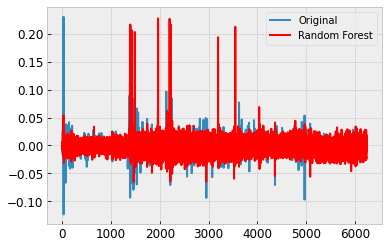

In [ ]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='Random Forest')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

depth = 8 MSE = 0.00003

depth = 16 MSE = 0.00002

depth = 32 MSE = 0.00002

So the optimal depth for this model should be 16

In [ ]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=300, max_depth=5)
reg.fit(X_train, y_train,
       verbose=False) # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.Rate, yhat)
predictionsDict['XGBoost'] = yhat

Test MSE: 0.00023110


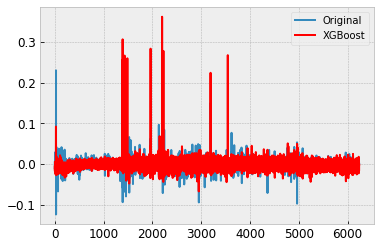

In [ ]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='XGBoost')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

300 estimator and 5 depth = 0.00002

1000 estimators and default depth = 0.00010

In [ ]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train,y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.Rate, yhat)
predictionsDict['Lightgbm'] = yhat

Test MSE: 0.00023268


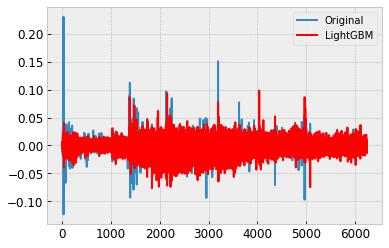

In [ ]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='LightGBM')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 50
WINDOW_LENGTH = 24
def window_data(X,Y,window=24):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x=[]
    y=[]
    for i in range(window-1,len(X)):
        x.append(X[i-window+1:i+1]) 
        y.append(Y[i])
    return np.array(x), np.array(y)
        
#Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w,y_w = window_data(X_w,y_w,window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

#Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [ ]:
dropout=0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=X_train_w.shape[-2:],dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

In [ ]:
EVALUATION_INTERVAL = len(X_train) / BATCH_SIZE
EPOCHS = 200

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data, validation_steps=20)

Epoch 1/200
241/241 [==============================] - 5s 13ms/step - loss: 0.1677 - val_loss: 0.0305
Epoch 2/200
241/241 [==============================] - 3s 11ms/step - loss: 0.0246 - val_loss: 0.0218
Epoch 3/200
241/241 [==============================] - 3s 11ms/step - loss: 0.0137 - val_loss: 0.0106
Epoch 4/200
241/241 [==============================] - 3s 11ms/step - loss: 0.0092 - val_loss: 0.0075
Epoch 5/200
241/241 [==============================] - 3s 11ms/step - loss: 0.0056 - val_loss: 0.0073
Epoch 6/200
241/241 [==============================] - 3s 11ms/step - loss: 0.0036 - val_loss: 0.0062
Epoch 7/200
241/241 [==============================] - 3s 11ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 8/200
241/241 [==============================] - 3s 11ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 9/200
241/241 [==============================] - 3s 11ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 10/200
241/241 [==============================] - 3s 11ms/step - loss: 0.001

In [ ]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1,-1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test,yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

In [ ]:
temp = 2.1468 #currency at starting date
results = []
for i in range(len(predictionsDict['Tensorflow simple LSTM'])):
  if i == 0:
    results.append(temp + predictionsDict['Tensorflow simple LSTM'][0])
    continue
  else:
    results.append(results[i - 1] + predictionsDict['Tensorflow simple LSTM'][i])


Test MSE: 0.00001942


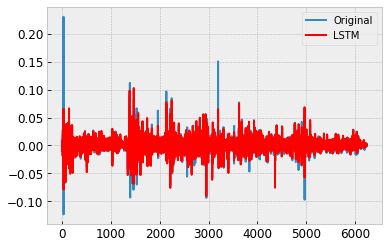

In [ ]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='LSTM')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
Window = 168
Result = 2.5

BATCH_SIZE = 512
BUFFER_SIZE = 1000
WINDOW_LENGTH = 120
Window = 120
Result = 0.8

BATCH_SIZE = 128
BUFFER_SIZE = 1000
WINDOW_LENGTH = 120
Window = 120
Result = 4.5

BATCH_SIZE = 128
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
window = 120
Result = 0.13

BATCH_SIZE = 128
BUFFER_SIZE = 50
WINDOW_LENGTH = 24
window = 24
Epoch = 50
Result = 0.03

# **ENSEMBLING**

In [ ]:
models = ['Tensorflow simple LSTM',
 'Lightgbm',
 'XGBoost']
resis = pd.DataFrame(data={k: df_test.Rate.values - v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,Tensorflow simple LSTM,Lightgbm,XGBoost
Tensorflow simple LSTM,1.000000,0.232354,0.175336
Lightgbm,0.232354,1.000000,0.594900
XGBoost,0.175336,0.594900,1.000000


In [ ]:
predictionsDict['EnsembleXG+LIGHT'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm'])/2
resultsDict['EnsembleXG+LIGHT'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleXG+LIGHT'])

predictionsDict['EnsembleXG+LIGHT+TF'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/3
resultsDict['EnsembleXG+LIGHT+TF'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleXG+LIGHT+TF'])

predictionsDict['EnsembleLIGHT+TF'] = (predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleLIGHT+TF'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleLIGHT+TF'])

predictionsDict['EnsembleXG+TF'] = (predictionsDict['XGBoost']+ predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleXG+TF'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleXG+TF'])

In [ ]:
import pickle

with open('scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import files
files.download('scores.pickle')
files.download('predictions.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open('tweets_scores.pickle', 'rb') as handle:
    resultsDict = pickle.load(handle)

with open('tweets_predictions.pickle', 'rb') as handle:
    predictionsDict = pickle.load(handle)